# Face Recognition with Tensorflow

### Teodor Kanev and Georgi Dimitrov

### 1. Problem

Face recognition is a method of identifying or verifying the identity of an individual from a digital image.
Our task for this project is to identify the exact position of the person face.

Example

### 2. Data source and preparation

<img src="https://lh3.googleusercontent.com/proxy/7bt85PH9LBhoq8jWHBCwtlBnS2tVe2G3pRNiwjy_UjTt-722itE-4HKLnRJG1B6CW3vEhzq_ImYlZ9mVmevLrRK46VlNADBwREn-xgQ">

The dataset we use can be found using the official website: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with <b>202,599</b> celebrity images. For every image, we have 4 values (X-coordinate of top left corner, Y-coordinate of top left corner, width and height of the box) describing a rectangle covering the face.

First of all, let's import some libraries and write help functions.

In [1]:
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
from skimage import color
from skimage import io
import pandas as pd
from PIL import Image
import collections

In [2]:
def to_index(name):
    return int(name[:6])

In [3]:
def to_name(index):
    name = ''
    for i in range(6 - len(str(index))):
        name += '0'
    name = name + str(index) + '.jpg'
    return name

The next function extracts all images located in given folder to <b>images</b> with size 64x64 and the original
size is stored in <b>sizes</b>. Every item in <b>images</b> is with shape (64,64,3) using that every image is
in rgb format.

In [4]:
def load_rgb_images_from_folder(folder):
    images = {}
    sizes = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None: 
            sizes[to_index(filename)] = img.size  
            new_img = img.resize((64,64), Image.ANTIALIAS)
            images[to_index(filename)] = new_img 
    return images, sizes

As we resize every image, we need to resize the bounding boxes aswell.

In [5]:
def change_bbox(name, old_w, old_h, df):
    df.at[to_index(name)-1, 'x_1'] *= (64/old_w)
    df.at[to_index(name)-1, 'y_1'] *= (64/old_h)
    df.at[to_index(name)-1, 'width'] *= (64/old_w)
    df.at[to_index(name)-1, 'height'] *= (64/old_h)

Saving all images in <b>train_imgs</b>

In [6]:
folder_name = 'Data/Part 1'
train_imgs, old_sizes = load_rgb_images_from_folder(folder_name)

Order them by image name in ordered dictionary.

In [7]:
od = collections.OrderedDict(sorted(train_imgs.items()))

Save bounding boxes(which are sorted by image name) in data frame.

In [8]:
df = pd.read_csv('Data/list_bbox_celeba.csv')

Scale bounding boxes for every image.

In [9]:
for i in od.keys():
    img_number = i
    change_bbox(to_name(img_number), old_sizes[img_number][0], old_sizes[img_number][1], df)

Convert images to numpy array

In [10]:
tst = []
for i in range(1,50000):
    tst.append(np.array(od[i]))

Use only needed bounding boxes.

In [11]:
labels = np.array(df.head(49999).drop(columns = ['image_id'], axis = 1))[:]

Shuffle images and bounding boxes.

In [12]:
from sklearn.utils import shuffle
images_shuffled, labels_shuffled = shuffle(tst, labels)

Split the dataset into: <br>
    <b> - Train data</b> - 80%<br>
    <b> - Validation data</b> - 10%<br>
    <b> - Test data</b> - 10%

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images_shuffled, labels_shuffled, test_size=0.2, random_state=7)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size = 0.5, random_state = 7)

Convert everything to numpyp array.

In [14]:
X_train = np.array(X_train)
Y_train = np.array(y_train)
X_val = np.array(X_val) 
Y_val = np.array(y_val)
X_test = np.array(X_test)
Y_test = np.array(y_test)

Import tensorflow libraries.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The model architecture.

In [16]:
model = keras.Sequential()
model.add(keras.Input(shape=(64, 64, 3)))
model.add(layers.Conv2D(64, kernel_size=(9, 9), strides=(1, 1), padding="same", activation = "relu"))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding="same", activation = "relu"))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.PReLU())
model.add(layers.Dense(4))

model.summary()
model.compile('Nadam', loss=tf.keras.losses.Huber())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        15616     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        16448     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

Train the data

In [17]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=1, batch_size=64)

Epoch 1/10
625/625 [==============================] - 454s 727ms/step - loss: 3.8680 - val_loss: 3.3998
Epoch 2/10
625/625 [==============================] - 450s 721ms/step - loss: 2.6273 - val_loss: 3.0933
Epoch 3/10
625/625 [==============================] - 451s 722ms/step - loss: 2.2144 - val_loss: 2.5477
Epoch 4/10
625/625 [==============================] - 451s 721ms/step - loss: 1.9260 - val_loss: 2.2990
Epoch 5/10
625/625 [==============================] - 450s 720ms/step - loss: 1.7033 - val_loss: 2.3786
Epoch 6/10
625/625 [==============================] - 450s 720ms/step - loss: 1.5149 - val_loss: 2.2269
Epoch 7/10
625/625 [==============================] - 451s 721ms/step - loss: 1.3571 - val_loss: 2.0307
Epoch 8/10
625/625 [==============================] - 451s 722ms/step - loss: 1.2253 - val_loss: 2.1407
Epoch 9/10
625/625 [==============================] - 451s 721ms/step - loss: 1.1058 - val_loss: 2.1141
Epoch 10/10
625/625 [==============================] - 451s 722m

Function for Intersection over Union metric to determine the model corectness.

In [18]:
def IOU(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

Function to calculate overall accuracy of the model.

In [19]:
def calc_accuracy(y_pred, y_test):
    tmp = []
    for i in range(len(y_pred)):
        tmp.append(IOU(y_pred[i], y_test[i]))
    
    return np.average(tmp)

Make predictions.

In [20]:
y_pred = model.predict(X_test)

Results.

In [21]:
calc_accuracy(y_pred, Y_test)

0.7280648649905351

Function to draw prediction bounding box on the image.

In [22]:
def draw_bbox(img, bbox):

    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

Some results.

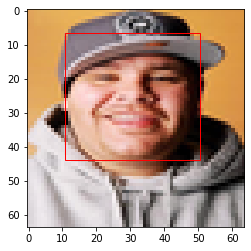

In [24]:
draw_bbox(X_test[7], y_pred[7])

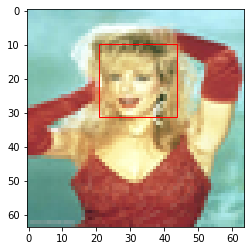

In [25]:
draw_bbox(X_test[17], y_pred[17])

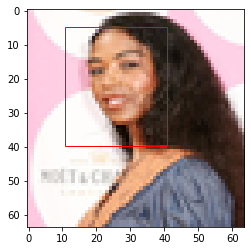

In [26]:
draw_bbox(X_test[27], y_pred[27])

Let's see where we fail to predict.

In [27]:
results = []
for i in range(1,500):
    results.append([IOU(Y_test[i], y_pred[i]),i])
results.sort()
results

[[0.0, 26],
 [0.0, 257],
 [0.0, 439],
 [0.07494826115996536, 494],
 [0.10050134501576498, 464],
 [0.1110568424193336, 110],
 [0.12082828041793743, 223],
 [0.1672918498630287, 127],
 [0.17627137625483158, 493],
 [0.1772292418780648, 275],
 [0.19798391486872097, 52],
 [0.20410339542072936, 63],
 [0.21236693548970642, 188],
 [0.22488818755127368, 145],
 [0.23121362827201572, 327],
 [0.24688068181974968, 179],
 [0.26947435950179904, 168],
 [0.29166254778298417, 492],
 [0.30148711387474414, 73],
 [0.30787787106826564, 355],
 [0.3161258674834911, 192],
 [0.3168079067396784, 382],
 [0.3195321445116698, 358],
 [0.3215060325426461, 302],
 [0.3215728883519337, 228],
 [0.32555571933536226, 28],
 [0.3282914262589583, 90],
 [0.33197158754751516, 361],
 [0.33879429819990237, 237],
 [0.3397241546170198, 258],
 [0.340141099578384, 65],
 [0.34079014750551634, 196],
 [0.3497209916500787, 236],
 [0.3644030981065735, 244],
 [0.3665407508288274, 108],
 [0.37828353170942675, 62],
 [0.3961109088852389, 49],


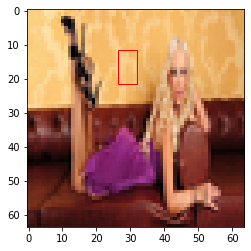

In [31]:
draw_bbox(X_test[26], y_pred[26])

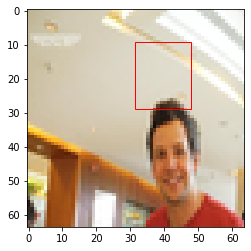

In [32]:
draw_bbox(X_test[257], y_pred[257])

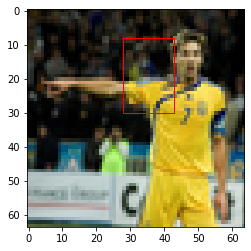

In [33]:
draw_bbox(X_test[439], y_pred[439])

In [ ]:
draw_bbox(X_test[19], y_pred[19])

Let's compare our model with the famous OPEN CV face recognition library - https://opencv.org/.

In [51]:
tst2 = tst[0:64]

In [74]:
cv_y = model.predict(tst2)

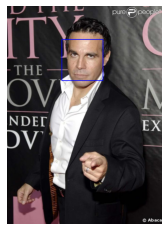

In [75]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('Data/Part 1/000008.jpg')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
# Display the output
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

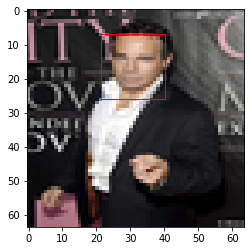

In [76]:
draw_bbox(tst2[7], cv_y[7])

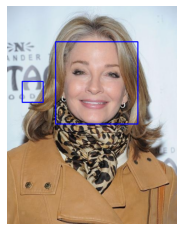

In [77]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('Data/Part 1/000018.jpg')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
# Display the output
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

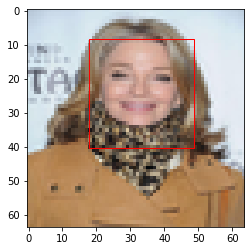

In [78]:
draw_bbox(tst2[17], cv_y[17])

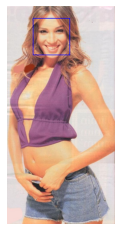

In [79]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('Data/Part 1/000028.jpg')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
# Display the output
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

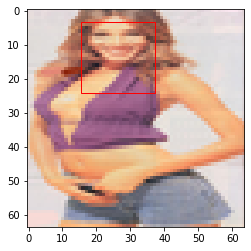

In [80]:
draw_bbox(tst2[27], cv_y[27])